In [1]:
from extract_features import process_dataset, load_and_process_sample
from visualization import signal_viewer
import matplotlib.pyplot as plt
from imu_pipeline import IMUPipeline
from pathlib import Path
import pandas as pd
import joblib
import os
import numpy as np

In [4]:
signal_viewer(
    data_dir=Path('data/raw/train'),
    labels_csv=Path('data/train.csv')
)

In [5]:
from extract_features import process_dataset
process_dataset('inference')

[INFO] No label CSV found for 'inference' – proceeding without labels.

Processing 'inference' dataset...


100%|██████████| 473/473 [00:04<00:00, 102.32it/s]


Processed 473 samples to data/inference.csv


,x_mean,x_std,x_max,x_min,x_range,x_skew,x_kurtosis,x_n_peaks,x_energy,y_mean,...,temperature,humidity,altitude,session_id,firmware_version,calibration_status,battery_level,gps_accuracy,network_type,device_model
0,0.058921,0.141937,0.263645,-0.227241,0.490886,-0.411727,-1.269705,17,2.361775,0.016296,...,29,21,383,S910846,v1.2.4,pending,97,5.613430,5g,model_b
1,0.106114,0.269372,1.778952,-0.216834,1.995787,3.211183,15.644389,1,8.382128,0.056256,...,15,58,163,S745147,v1.3.0,pending,60,1.196678,5g,model_b
2,0.789526,2.145882,9.063698,-5.985732,15.049430,0.780326,3.492323,11,522.816335,0.819377,...,32,55,838,S815741,v1.3.0,ok,39,3.882185,wifi,model_b
3,0.608177,1.767987,7.425284,-5.526085,12.951369,0.051386,2.937480,15,349.565584,1.388228,...,24,71,166,S192238,v1.2.3,ok,46,3.886005,wifi,model_b
4,-1.194933,1.703552,5.421388,-5.423952,10.845341,1.637340,4.764184,5,432.995344,-0.195628,...,27,52,720,S146695,v1.2.3,recent,36,7.753421,4g,model_a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,-1.636018,1.836926,6.591974,-9.584012,16.175985,0.312256,7.618219,3,605.085057,1.075774,...,24,75,720,S259109,v1.2.3,ok,76,3.351859,5g,model_b
469,0.060071,0.144546,0.310245,-0.195478,0.505723,-0.337960,-1.312457,13,2.450196,0.015352,...,17,78,945,S852576,v1.2.4,ok,91,6.921099,5g,model_b
470,0.558987,1.950833,8.567100,-4.938564,13.505664,0.908525,4.674787,8,411.821559,-0.130941,...,30,34,574,S639486,v1.2.3,recent,95,8.046290,4g,model_a
471,0.102132,0.273789,1.820321,-0.219719,2.040041,3.268718,16.336809,1,8.539161,0.016576,...,26,23,55,S935107,v1.2.4,ok,76,7.027533,4g,model_a


In [6]:
import pandas as pd
labels = pd.read_csv("data/manual_annotation/inference_labels.csv")

In [8]:
import joblib
from imu_pipeline import IMUPipeline

df_inf = pd.read_csv("data/inference.csv")
model = joblib.load("models/imu_pipeline.pkl")

preds = model.predict(df_inf)
probs = model.predict_proba(df_inf)

In order to proceed with the task, we first implement evaluation functions

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def print_classification_metrics(y_true, y_pred, y_pred_proba):
    """
    Calculate and print all standard binary classification metrics

    Parameters:
    y_true: true labels
    y_pred: predicted labels
    y_pred_proba: predicted probabilities for the positive class (optional)
    """
    # Calculate basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_proba)


    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    print("Classification Metrics:")
    print("-" * 50)
    print(f"Accuracy:    {accuracy:.4f}")
    print(f"Precision:   {precision:.4f}")
    print(f"Recall:      {recall:.4f}")
    print(f"F1 Score:    {f1:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")


    print("\nConfusion Matrix:")
    print("-" * 50)
    print(f"True Negatives:  {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives:  {tp}")

    return {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'roc auc': roc_auc
    }

In [10]:
def evaluate_model(model, X, y):
    """
    Evaluates the performance of a given classification model on the provided dataset.

    The function calculates various classification metrics by comparing model predictions
    and probabilities against the true labels. It outputs the metrics to standard output
    and provides insight into the classification quality of the given model.

    Args:
        model: The classification model implementing the `predict` and `predict_proba` methods.
        X: Features used for prediction. Should be compatible with the model.
        y: True labels for classification evaluation.

    Returns:
        dict of metrics
    """
    preds = model.predict(X)
    preds = np.where(preds == 'normal', 1, 0)
    y = np.where(y == 'normal', 1, 0)

    probs = model.predict_proba(X)

    return print_classification_metrics(
    y_true=y,
    y_pred=preds,
    y_pred_proba=probs[:, 1]  # For ROC AUC, use probabilities of positive class
    )

We prepare the inference dataset for evaluation by merging the features dataframe with the CSV labels file using the sample_id column as the key.

In [11]:
x_inference = df_inf.reset_index().rename(columns={'index': 'original_order'})

# Merge the dataframes on sample_id
X_inference = x_inference.merge(labels, on='sample_id', how='left')

# Sort back to original order if needed
X_inference = X_inference.sort_values('original_order').drop('original_order', axis=1)

x_inference = X_inference.drop('label', axis=1)
y_inference = X_inference['label'].values

In [12]:
inference_metrics = evaluate_model(model, x_inference, y_inference)

Classification Metrics:
--------------------------------------------------
Accuracy:    0.6448
Precision:   0.8876
Recall:      0.3333
F1 Score:    0.4847
ROC AUC Score: 0.7611

Confusion Matrix:
--------------------------------------------------
True Negatives:  226
False Positives: 10
False Negatives: 158
True Positives:  79


In [13]:
test_df = pd.read_csv("data/test.csv")
x_test = test_df.drop('label', axis=1)
y_test = test_df['label']
test_metrics = evaluate_model(model, x_test, y_test)

Classification Metrics:
--------------------------------------------------
Accuracy:    0.9450
Precision:   0.9009
Recall:      1.0000
F1 Score:    0.9479
ROC AUC Score: 0.9282

Confusion Matrix:
--------------------------------------------------
True Negatives:  89
False Positives: 11
False Negatives: 0
True Positives:  100


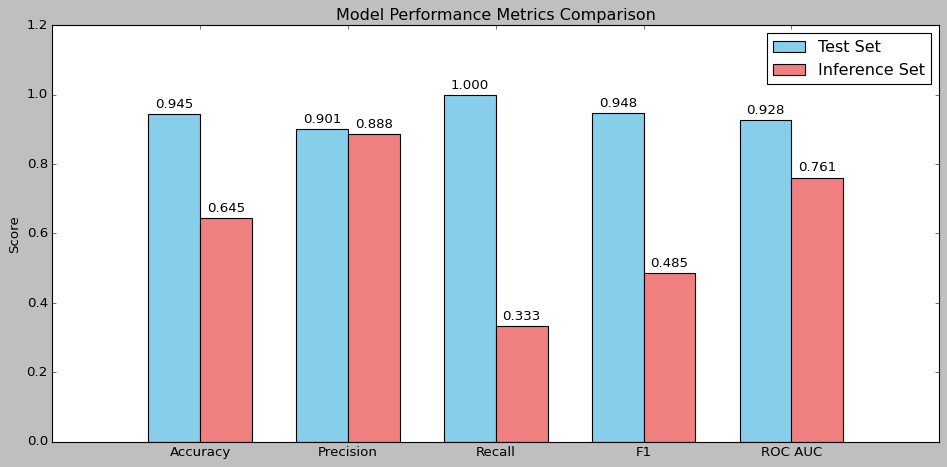

In [14]:
plt.style.use('classic')

# Prepare data
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC']
test_values = [test_metrics[m.lower()] for m in metrics]
inf_values = [inference_metrics[m.lower()] for m in metrics]

# Set up positions for bars
x = np.arange(len(metrics))
width = 0.35

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Create bars
rects1 = ax.bar(x - width/2, test_values, width, label='Test Set', color='skyblue')
rects2 = ax.bar(x + width/2, inf_values, width, label='Inference Set', color='lightcoral')

# Customize plot
ax.set_ylabel('Score')
ax.set_title('Model Performance Metrics Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1.2)  # Set y-axis limit to 1.2
ax.legend()

# Add value labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Adjust layout and display
fig.tight_layout()
plt.show()

We can see that the model performed significantly better on the test set than on the inference set, achieving higher scores across all evaluation metrics.
Now we will dive in the data in order to locate the source of the problem, leading to the performance discrepancy.

In [16]:
# Load datasets
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
inference_df = pd.read_csv("data/inference.csv")

We use the training data as well to see on what patterns the model was trained.

In [20]:
def plot_numeric_features(train_df, test_df, inference_df):
    # Remove label column from train and test sets for feature comparison
    cols_to_drop = ['label', 'driver_id', 'sample_id', 'timestamp', 'session_id']
    X_train = train_df.drop(cols_to_drop, axis=1)
    X_test = test_df.drop(cols_to_drop, axis=1)
    X_inference = inference_df.drop(cols_to_drop[1:], axis=1)

    # Get numeric features
    numeric_features = X_train.select_dtypes(include=[np.number]).columns
    n_features = len(numeric_features)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    axes = axes.flatten()

    for idx, feature in enumerate(numeric_features):
        # Prepare data for box plots
        data = [
            X_train[feature],
            X_test[feature],
            X_inference[feature]
        ]

        # Create box plot
        bp = axes[idx].boxplot(data, labels=['Train', 'Test', 'Inference'])

        # Customize plot
        axes[idx].set_title(f'Distribution of {feature}')
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].grid(True, alpha=0.3)

    # Remove empty subplots if any
    for idx in range(len(numeric_features), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()


    print("\nSummary Statistics for Numeric Features:")
    summary_stats = []
    for feature in numeric_features:
        feature_stats = {
            'Feature': feature,
            'Train_mean': X_train[feature].mean(),
            'Train_std': X_train[feature].std(),
            'Test_mean': X_test[feature].mean(),
            'Test_std': X_test[feature].std(),
            'Inference_mean': X_inference[feature].mean(),
            'Inference_std': X_inference[feature].std()
        }
        summary_stats.append(feature_stats)

    stats_df = pd.DataFrame(summary_stats)
    pd.set_option('display.max_columns', None)
    print(stats_df.round(3).to_string(index=False))

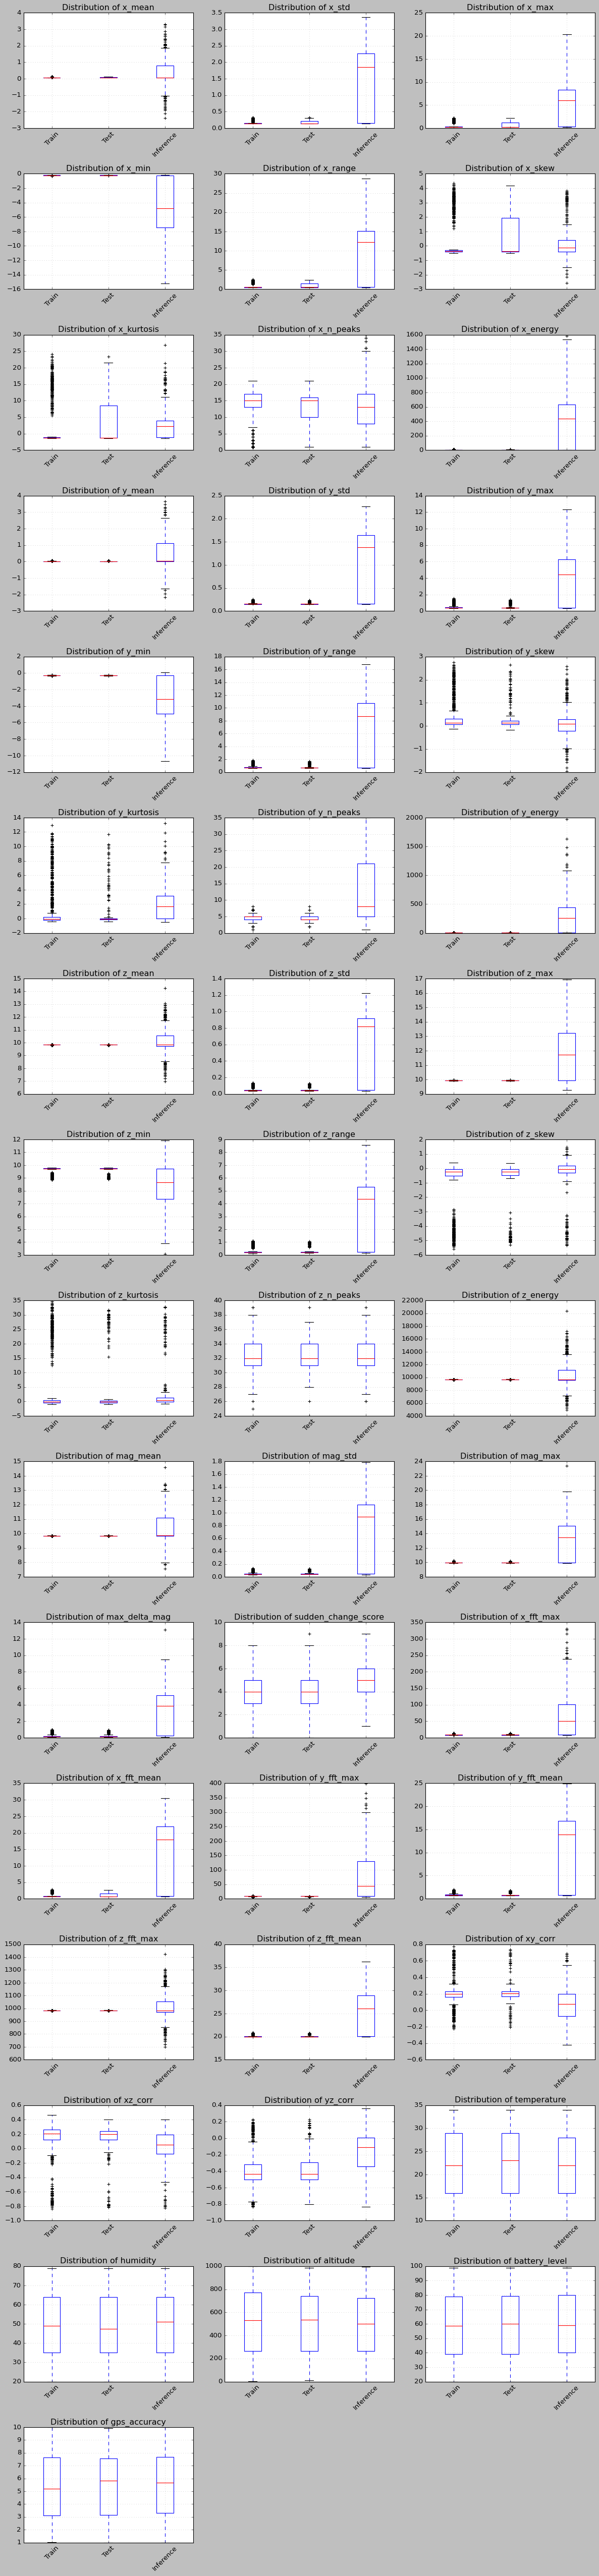


Summary Statistics for Numeric Features:
            Feature  Train_mean  Train_std  Test_mean  Test_std  Inference_mean  Inference_std
             x_mean       0.070      0.016      0.072     0.018           0.334          0.864
              x_std       0.166      0.046      0.176     0.056           1.473          1.006
              x_max       0.556      0.559      0.664     0.659           5.338          3.973
              x_min      -0.220      0.018     -0.220     0.016          -4.532          3.744
            x_range       0.777      0.560      0.885     0.662           9.870          7.181
             x_skew       0.303      1.374      0.560     1.596           0.156          1.030
         x_kurtosis       1.937      6.624      3.203     7.764           2.965          4.485
          x_n_peaks      13.568      5.053     12.545     5.871          12.953          6.809
           x_energy       3.484      2.179      3.956     2.676         403.629        352.366
        

In [21]:
plot_numeric_features(train_df, test_df, inference_df)

Regarding the numerical features, there is a notable difference in the distribution of sensor data between the inference set and both the training and test sets. The close similarity between the training and test distributions explains the model’s strong performance on the test set. In contrast, the inference set exhibits a substantially different distribution of values, which accounts for the poorer performance observed during inference.

Although the sensor-derived features exhibit different distributions across the datasets, the features related to the driving conditions (e.g., battery status, GPS, and weather) remain consistent. This indicates that the observed discrepancy is primarily attributable to variations in the sensor data collection rather than differences in external conditions.

We will now examined the categorical features.

In [24]:
def plot_categorical_features(train_df, test_df, inference_df):

    cols_to_drop = ['label', 'driver_id', 'sample_id', 'timestamp', 'session_id']
    X_train = train_df.drop(cols_to_drop, axis=1)
    X_test = test_df.drop(cols_to_drop, axis=1)
    X_inference = inference_df.drop(cols_to_drop[1:], axis=1)
    non_numeric_features = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

    n_features = len(non_numeric_features)
    fig, axes = plt.subplots(n_features, 1, figsize=(12, 5*n_features))

    # Handle single feature case
    if n_features == 1:
        axes = [axes]

    for idx, feature in enumerate(non_numeric_features):
        # Get value counts as percentages for each dataset
        train_counts = X_train[feature].value_counts(normalize=True)
        test_counts = X_test[feature].value_counts(normalize=True)
        inf_counts = X_inference[feature].value_counts(normalize=True)

        # Get all unique categories
        all_categories = sorted(set(train_counts.index) | set(test_counts.index) | set(inf_counts.index))

        # Create arrays for plotting, filling missing values with 0
        train_vals = [train_counts.get(cat, 0) * 100 for cat in all_categories]
        test_vals = [test_counts.get(cat, 0) * 100 for cat in all_categories]
        inf_vals = [inf_counts.get(cat, 0) * 100 for cat in all_categories]

        # Set up bar positions
        x = np.arange(len(all_categories))
        width = 0.25

        # Create bars
        axes[idx].bar(x - width, train_vals, width, label='Train', color='skyblue')
        axes[idx].bar(x, test_vals, width, label='Test', color='lightgreen')
        axes[idx].bar(x + width, inf_vals, width, label='Inference', color='lightcoral')

        # Customize plot
        axes[idx].set_title(f'Distribution of {feature} Values')
        axes[idx].set_xlabel('Categories')
        axes[idx].set_ylabel('Percentage (%)')
        axes[idx].set_xticks(x)
        axes[idx].set_xticklabels(all_categories, rotation=45, ha='right')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

        # Add percentage labels on top of bars
        for i, vals in enumerate(zip(train_vals, test_vals, inf_vals)):
            for j, v in enumerate(vals):
                if v > 0:  # Only add label if value is non-zero
                    axes[idx].text(i + (j-1)*width, v, f'{v:.1f}%',
                                 ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    print("\nDetailed Distribution of Non-numeric Features:")
    for feature in non_numeric_features:
        print(f"\nFeature: {feature}")

        # Create a DataFrame to show side-by-side comparison
        comparison_df = pd.DataFrame({
            'Train %': X_train[feature].value_counts(normalize=True) * 100,
            'Test %': X_test[feature].value_counts(normalize=True) * 100,
            'Inference %': X_inference[feature].value_counts(normalize=True) * 100
        }).round(2)

        # Fill NaN with 0 for categories not present in some datasets
        comparison_df = comparison_df.fillna(0.0)

        # Sort by index for consistency
        comparison_df = comparison_df.sort_index()

        print(comparison_df)

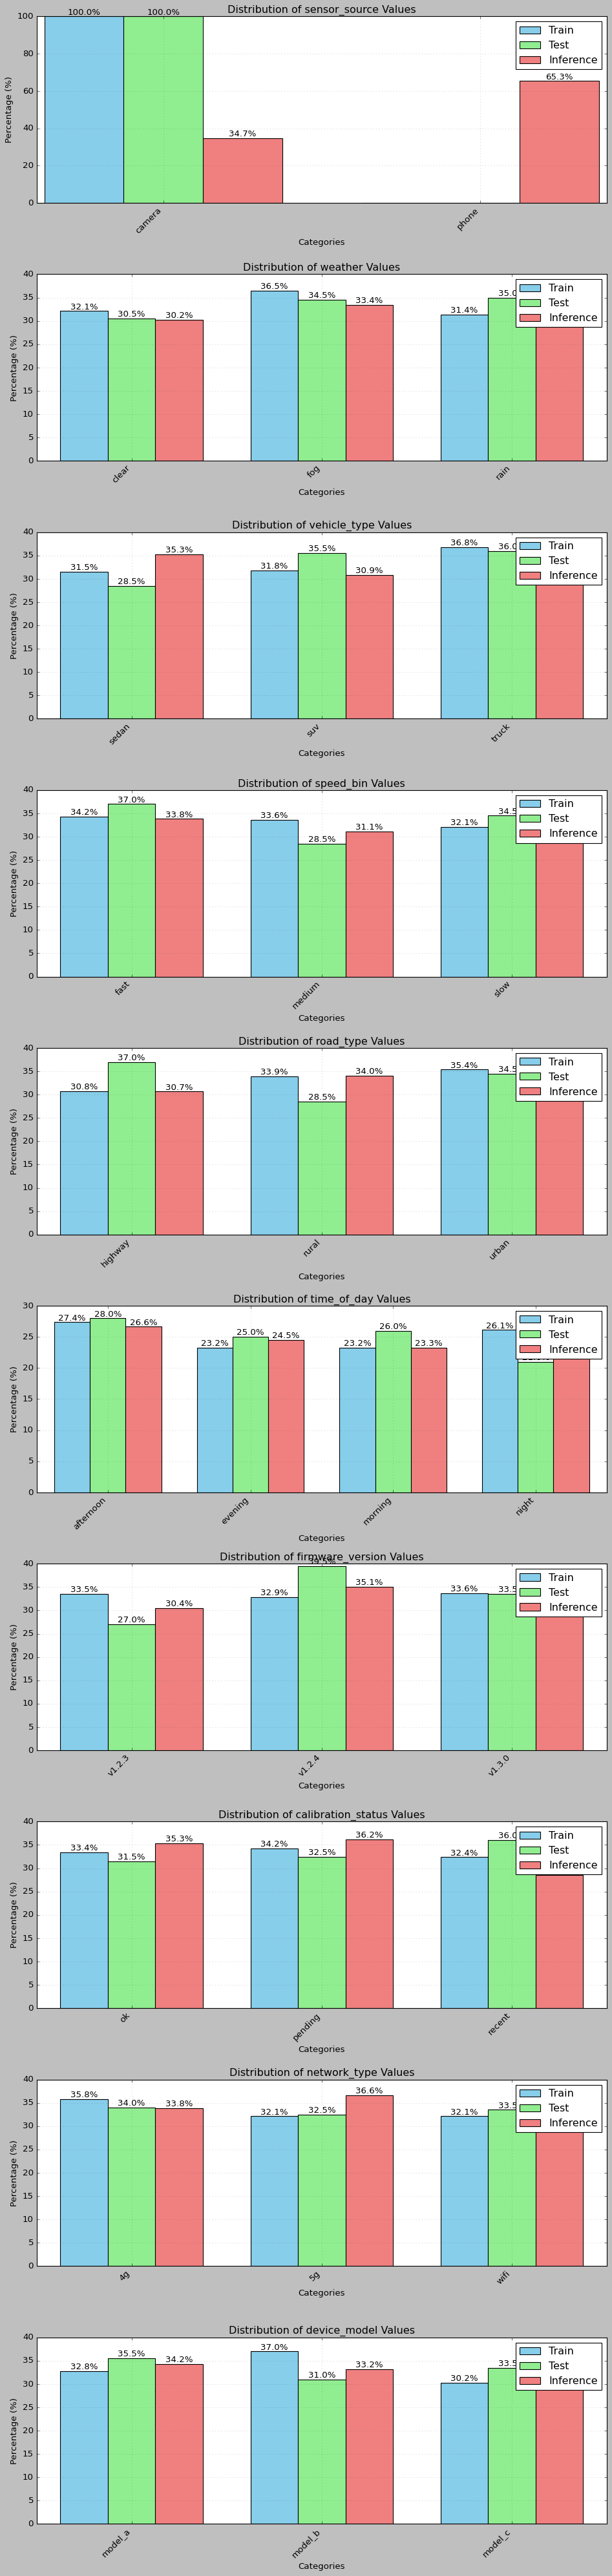


Detailed Distribution of Non-numeric Features:

Feature: sensor_source
               Train %  Test %  Inference %
sensor_source                              
camera           100.0   100.0        34.67
phone              0.0     0.0        65.33

Feature: weather
         Train %  Test %  Inference %
weather                              
clear      32.12    30.5        30.23
fog        36.50    34.5        33.40
rain       31.37    35.0        36.36

Feature: vehicle_type
              Train %  Test %  Inference %
vehicle_type                              
sedan           31.50    28.5        35.31
suv             31.75    35.5        30.87
truck           36.75    36.0        33.83

Feature: speed_bin
           Train %  Test %  Inference %
speed_bin                              
fast         34.25    37.0        33.83
medium       33.62    28.5        31.08
slow         32.12    34.5        35.10

Feature: road_type
           Train %  Test %  Inference %
road_type                 

In [23]:
plot_categorical_features(train_df, test_df, inference_df)

We can identify a key difference in the sensor_source feature: while all data in the training and test sets was collected using cameras, the majority of data in the inference set was collected via mobile phones. This shift likely explains the deviation from the training distribution, as phone sensors capture and record information differently compared to dedicated cameras.

We will now verify whether this is indeed the source of the problem by evaluating the model exclusively on the subset of data collected via cameras.

In [26]:
x_inference = df_inf.reset_index().rename(columns={'index': 'original_order'})

# Merge the dataframes on sample_id
X_inference = x_inference.merge(labels, on='sample_id', how='left')
X_inference = X_inference[X_inference['sensor_source']=='camera']

# Sort back to original order if needed
X_inference = X_inference.sort_values('original_order').drop('original_order', axis=1)

new_x_inference = X_inference.drop('label', axis=1)
new_y_inference = X_inference['label'].values

In [27]:
new_inference_metrics = evaluate_model(model, new_x_inference, new_y_inference)

Classification Metrics:
--------------------------------------------------
Accuracy:    0.9390
Precision:   0.8876
Recall:      1.0000
F1 Score:    0.9405
ROC AUC Score: 0.9209

Confusion Matrix:
--------------------------------------------------
True Negatives:  75
False Positives: 10
False Negatives: 0
True Positives:  79


As expected, the model performed strongly on the subset of the inference dataset collected via cameras, achieving high results comparable to those obtained on the test set.

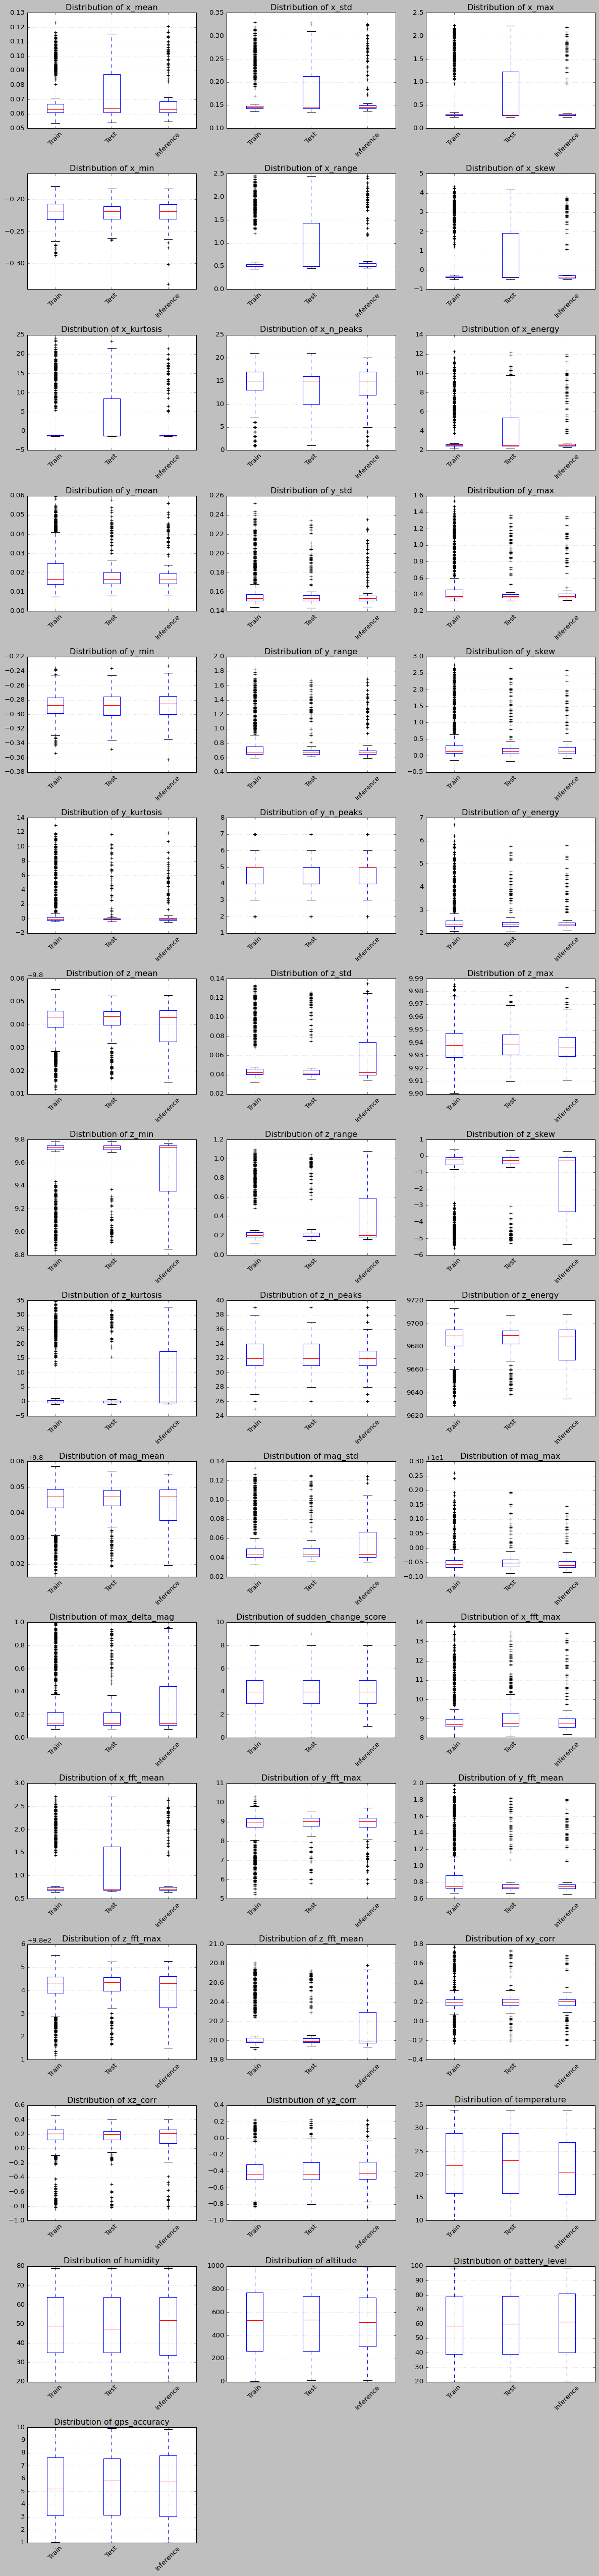


Summary Statistics for Numeric Features:
            Feature  Train_mean  Train_std  Test_mean  Test_std  Inference_mean  Inference_std
             x_mean       0.070      0.016      0.072     0.018           0.071          0.017
              x_std       0.166      0.046      0.176     0.056           0.170          0.051
              x_max       0.556      0.559      0.664     0.659           0.592          0.596
              x_min      -0.220      0.018     -0.220     0.016          -0.222          0.021
            x_range       0.777      0.560      0.885     0.662           0.813          0.597
             x_skew       0.303      1.374      0.560     1.596           0.361          1.425
         x_kurtosis       1.937      6.624      3.203     7.764           2.199          6.720
          x_n_peaks      13.568      5.053     12.545     5.871          13.146          5.498
           x_energy       3.484      2.179      3.956     2.676           3.671          2.455
        

In [28]:
plot_numeric_features(train_df, test_df, X_inference)

Moreover, after removing the records collected via mobile phones, the feature distributions across the datasets become relatively consistent, indicating that the discrepancy was primarily introduced by the phone-based data.

Thus, we can conclude that the performance discrepancy arises from the different distributions of sensor values collected via mobile phones in the sensor_source feature.

Immediate Workarounds:

1. Apply a mathematical transformation that maps phone sensor values into camera-like ranges.
   - Pros: Improves model performance on the new domain (phone-collected data) without requiring full retraining.
   - Cons: Effectiveness depends on the quality of the inference data and may introduce additional complexity into the system.

2. Support only data collected via cameras.
   - Pros: Provides an immediate fix by ensuring consistency with the training distribution, thereby avoiding the degraded performance observed on phone-collected data.
   - Cons: Excludes customers who rely on mobile-phone data collection, which could negatively impact adoption and business outcomes.


Long-term Fix:
1. Integrate phone-based data into the training process, either through fine-tuning or full retraining, to reduce the distribution gap.
   - Pros: Enables the model to generalize across both camera and phone domains, improving robustness and reducing sensitivity to sensor variations.
   - Cons: Requires actively gathering and labeling sufficient phone-collected data. Performance may become balanced across devices but slightly lower than the camera-only baseline.

2. Develop and maintain a dedicated model for each type of sensor (e.g., cameras vs. mobile phones).
   - Pros: Each model is specialized for its domain, leading to strong within-domain performance. Adding new device types only requires training an additional model, without modifying existing ones.
   - Cons: Increases operational complexity, as multiple models must be managed, trained, and deployed. Requires inference-time routing logic to select the appropriate model based on the sensor source.

# ❓ Questions to Reflect On


- What do you observe when comparing the model’s predictions on the new data to its known performance?

    Answer - *There was a significant discrepancy in the model’s performance, with a notably higher number of false negatives. This indicates that many collisions were incorrectly classified as normal records.*

- Is there anything in the data that might explain differences in behavior?

    Answer - *Yes, there is a substantial difference between the distributions of the sensor values in the training dataset compared to those in the inference dataset.*

- Can you identify patterns or trends related to when the model succeeds or fails?

    Answer - *Yes, the model primarily fails when the data is collected from mobile phones, which explains the deviation in sensor value distributions.*

- Are there signals or features that seem to affect the model’s reliability?

    Answer - *Yes, the model’s reliability is strongly affected by the sensor_source feature, it performs well on camera-collected data but fails more often on phone-collected data due to distributional shifts in the sensor values.*

- What could be done in the short term to handle the current situation?

    Answer - *the distribution gap can be addressed either by applying a mathematical transformation to map phone sensor values into camera-like ranges, improving model performance but adding complexity, or by restricting support to camera-collected data, which ensures consistency with training but excludes customers relying on mobile phones.*

- What are potential long-term steps to improve model performance in similar scenarios?

    Answer - *For long-term solutions, the model can be adapted by integrating phone-collected data into training, improving robustness across domains but requiring additional labeled data and potentially lowering peak performance, or by developing separate models for each sensor type, which ensures strong domain specialization but increases operational complexity and necessitates inference-time routing.*

- What would you want to explore further if given more time or data?

    Answer - *Given more data collected from multiple devices, I would dedicate additional time to exploring the effectiveness of the proposed solutions and evaluating their impact on model performance, both in terms of classification metrics and latency, in order to assess which approach is most suitable for deployment in a production environment.*

- What assumptions did the model rely on during training — and are they still valid?

    Answer - *The assumption that most machine learning models rely on is that the data the model encounters during inference will behave the same as the data used for training and testing. In this case, however, the assumption does not hold, as the model is exposed to a completely different range of feature values during inference. This distributional shift leads to a significant degradation in model performance.*